# Setup

In [1]:
DATA_VERSION = "2025-06-09"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

# Do not train nor test on documents from cantons that have known data quality issues.
EXCLUDE_POLITICAL_BODIES = {
    "bl",
    "ge",
    "ne",
    "sz",
    "vd",
    "vs",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # These are labels after class merging.
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
    "SURVEY",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.2
RANDOM_STATE = 2718
USE_TEST_SET = True

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/pandera/_pandas_deprecated.py:157: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s %(name)s: %(message)s")

In [5]:
dotenv.load_dotenv()

True

In [6]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("exclude_political_bodies", sorted(EXCLUDE_POLITICAL_BODIES))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)

mlflow.sklearn.autolog()

Starting run: grandiose-grouse-888


2025/06/09 14:05:31 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

## Get all dataframes

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-06-09.parquet already exists locally.
INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-features-2025-06-09.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-06-09.parquet
INFO download_file_from_exoscale: Downloading dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-06-09.parquet from bucket demokratis-ml to /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-06-09.parquet


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE, only_languages=LANGUAGES, starting_year=FROM_YEAR
)
df_docs

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7780,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7783,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7786,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7789,fedlex,manual,fedlex,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,7792,fedlex,manual,fedlex,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53540,55487,5150,2025-06-06,2025-09-05,Umsetzung TAXOPTIMA (Leitsätze 18-20 der Steue...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/9bhve7yc,[],[],...,Regierungsrat des Kantons Aargau,ag,50933,openparldata,openparldata,NaN,6. Juni 2025\nSehr geehrte Damen und Herren\nA...,2025/5150/55487/1CPx5d9fv8U88YPrxKh9PH.pdf,application/pdf,bfab4f27b70fd4eb3a8386b85f52f57fddfc206c
53541,55488,5150,2025-06-06,2025-09-05,Umsetzung TAXOPTIMA (Leitsätze 18-20 der Steue...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/9bhve7yc,[],[],...,Regierungsrat des Kantons Aargau,ag,50931,openparldata,openparldata,NaN,Arbeitsversion (ID: 3558) \n \nSynopse Beilag...,2025/5150/55488/1CPx5d8Lowktjkrc8dP8yf.pdf,application/pdf,bca367227769baeac7d845c35496

In [9]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
55487,bfab4f27b70fd4eb3a8386b85f52f57fddfc206c,False,2,0.0,0.0,2.0,2.0,0.706972
55488,bca367227769baeac7d845c35496c1bd7364368e,True,34,34.0,34.0,0.0,0.0,1.414516
55489,a418cbc7ea91205481639ff7b989195626ebd74a,True,5,5.0,5.0,0.0,0.0,1.414516


In [10]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
55487,"[-0.017950385808944702, -0.012628879398107529,..."
55488,"[0.028708305209875107, -0.016753576695919037, ..."
55489,"[-0.03162379562854767, -0.012206255458295345, ..."


In [11]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


## Preprocess

In [12]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
)

INFO document_types.preprocessing: Dropping 1269 documents (5.4%) with empty texts
/Users/vita/Code/demokratis/demokratis-ml/demokratis_ml/models/document_types/features.py:56: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["consultation_start_timestamp"] = df["consultation_start_date"].view("int64") // 10**9
INFO document_types.features: 3385 rows (15.2%) were lost due to missing features. Remaining rows: 18948. 15 columns were added.
INFO document_types.features: Lost documents by political_body/year:
year            2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024   Total
political_body                                                                                                                    
ag                 0     0     0     0     0    53    17    21     6     0    41     3    59    58    18    24     5     3   308.0
ai  

In [13]:
print(
    "Excluding documents from these political bodies from the data:",
    df_input[df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]["political_body"].astype(str).value_counts(),
    sep="\n",
)
df_input = df_input[~df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]

Excluding documents from these political bodies from the data:
political_body
sz    345
vs     12
bl      9
Name: count, dtype: int64


## Split

In [14]:
df_input_train, df_input_test = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.28% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.05% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.13% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.13% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.03% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_ru

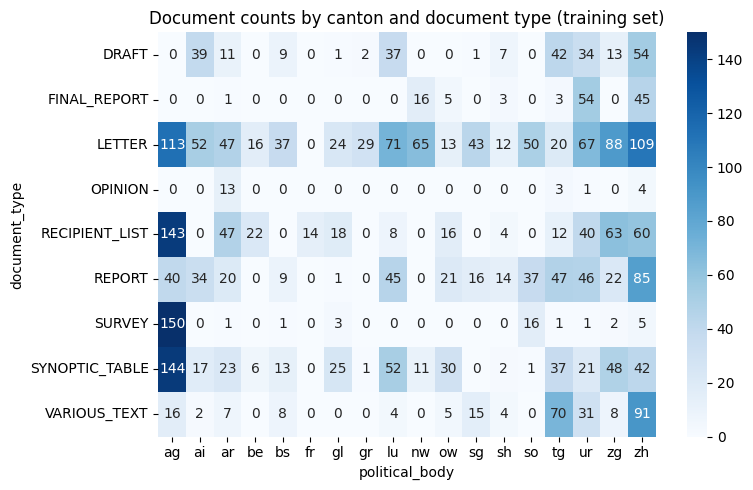

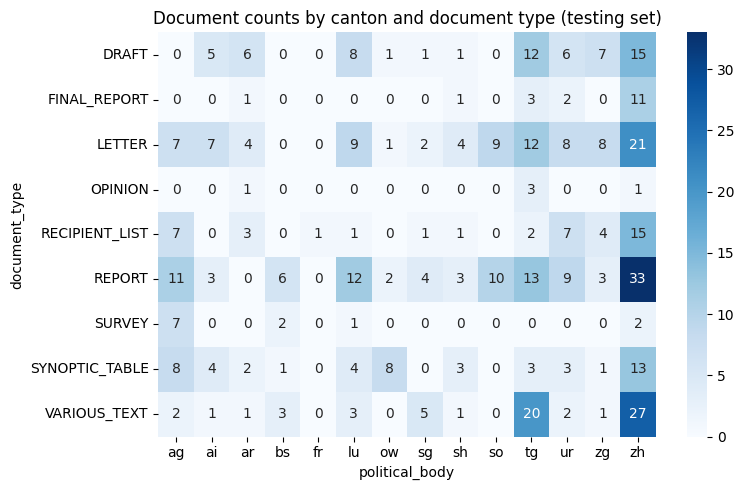

In [15]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test, "testing")

In [16]:
display(df_input_train["document_type_label_source"].value_counts(dropna=False))
display(df_input_train["document_type"].value_counts(dropna=False))

document_type_label_source
fedlex    12223
manual     1822
rule       1230
Name: count, dtype: int64

document_type
LETTER            3306
DRAFT             3070
REPORT            2531
RECIPIENT_LIST    2173
FINAL_REPORT      1842
OPINION            896
VARIOUS_TEXT       666
SYNOPTIC_TABLE     588
SURVEY             203
DECISION             0
LINK                 0
PRESS_RELEASE        0
RESPONSE_FORM        0
Name: count, dtype: int64

In [17]:
display(df_input_test["document_type_label_source"].value_counts(dropna=False))
display(df_input_test["document_type"].value_counts(dropna=False))

document_type_label_source
manual    456
rule        0
fedlex      0
Name: count, dtype: int64

document_type
REPORT            109
LETTER             92
VARIOUS_TEXT       66
DRAFT              62
SYNOPTIC_TABLE     50
RECIPIENT_LIST     42
FINAL_REPORT       18
SURVEY             12
OPINION             5
DECISION            0
LINK                0
PRESS_RELEASE       0
RESPONSE_FORM       0
Name: count, dtype: int64

In [18]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

456

# Data exploration

## Data representation

In [19]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source", observed=False)["document_type"].value_counts(dropna=False)

df_input_train labels:


document_type_label_source  document_type 
rule                        LETTER             488
                            RECIPIENT_LIST     280
                            SYNOPTIC_TABLE     275
                            SURVEY             131
                            FINAL_REPORT        56
                            DECISION             0
                            DRAFT                0
                            LINK                 0
                            OPINION              0
                            PRESS_RELEASE        0
                            REPORT               0
                            RESPONSE_FORM        0
                            VARIOUS_TEXT         0
manual                      REPORT             437
                            LETTER             368
                            VARIOUS_TEXT       261
                            DRAFT              250
                            SYNOPTIC_TABLE     198
                            RECIPIENT_L

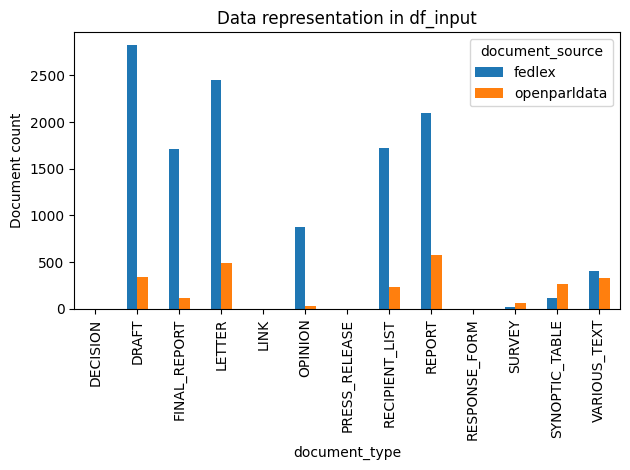

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2820,344
FINAL_REPORT,1715,111
LETTER,2450,493
LINK,0,0
OPINION,875,27
PRESS_RELEASE,0,0
RECIPIENT_LIST,1726,239
REPORT,2094,578


In [20]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [21]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001064,0.000000
FINAL_REPORT,0.002915,0.036036
LETTER,0.985306,0.995943
OPINION,0.750857,0.666667
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.013372,0.043253
SURVEY,0.000000,0.047619
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.014815,0.009091


### Keyword-like features

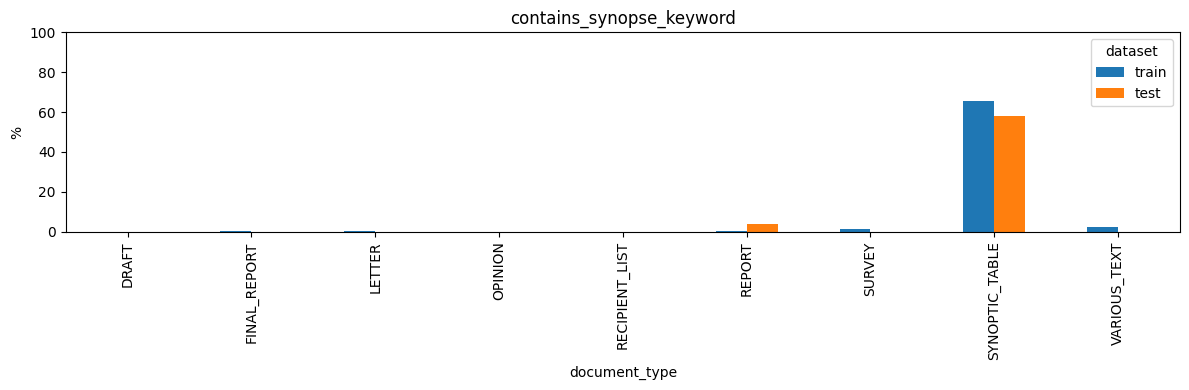

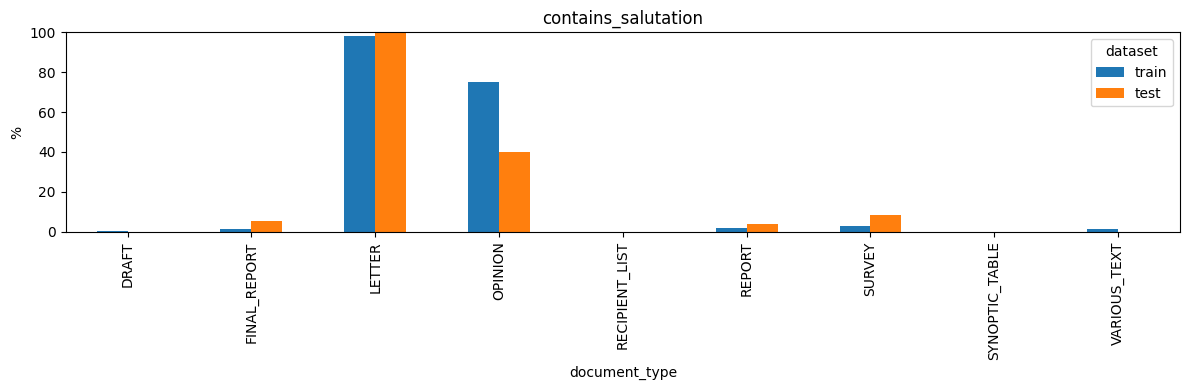

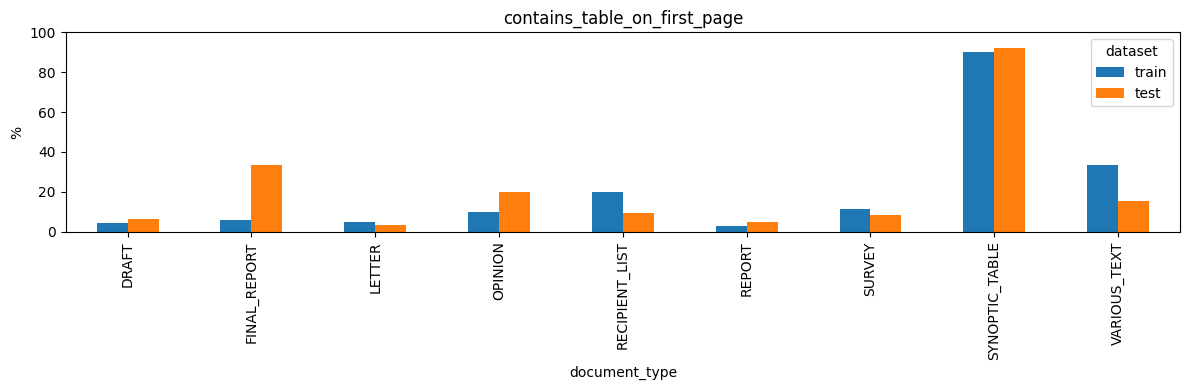

In [22]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_table_on_first_page")

In [23]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

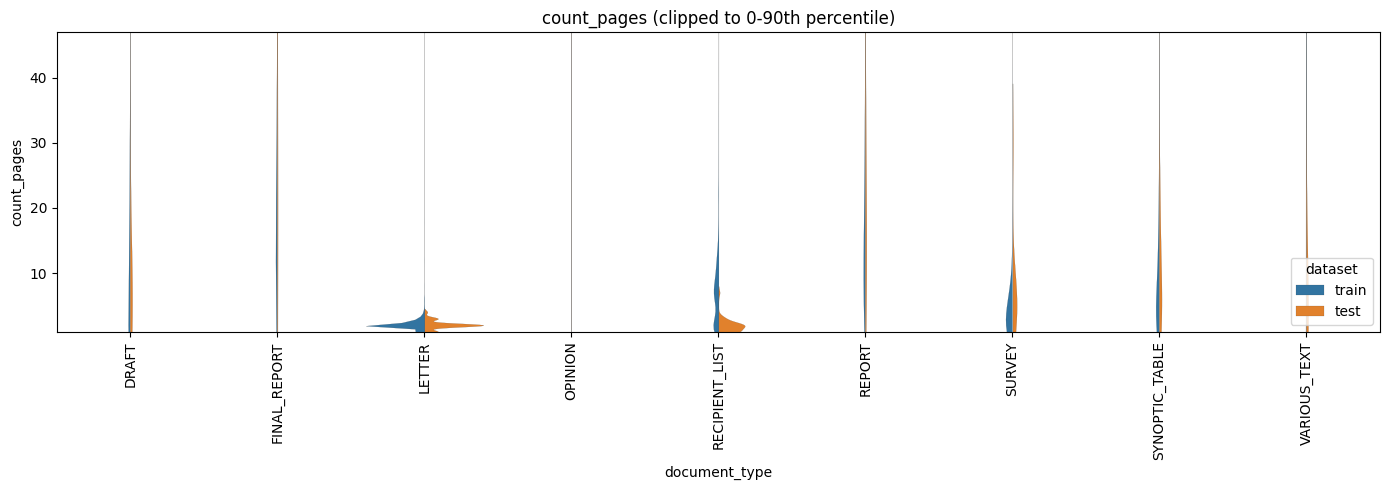

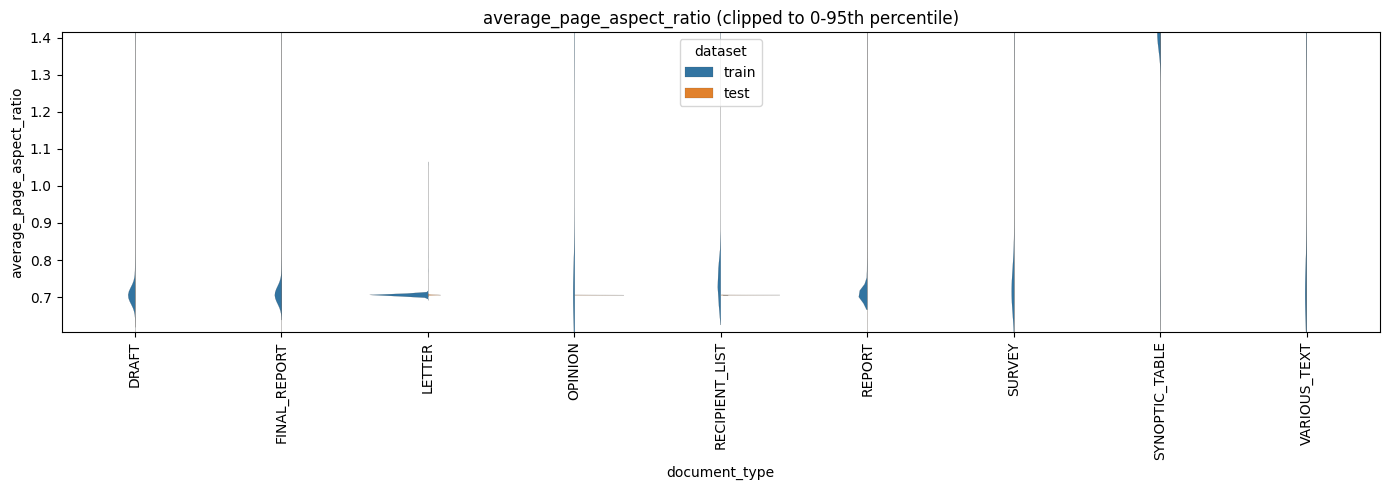

In [24]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [25]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                     std            
dataset               test       train        test       train
document_type                                                 
DRAFT            11.032258   13.765798   19.228537   45.423479
FINAL_REPORT     35.166667   26.934853   54.880887   43.688830
LETTER            2.065217    2.148820    0.659743    1.384240
OPINION         135.400000  358.755580  259.346872  700.740868
RECIPIENT_LIST    1.857143    7.128394    1.049307    5.421428
REPORT           25.816514   24.499407   26.772763   29.432087
SURVEY            7.333333    4.467980    7.523700    7.011498
SYNOPTIC_TABLE   11.340000   11.086735   13.743436   14.573352
VARIOUS_TEXT     10.181818   21.085586   21.318038  152.864184

In [26]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.722538  0.728731  0.096159  0.111110
FINAL_REPORT    0.924970  0.726669  0.297970  0.102148
LETTER          0.707119  0.707790  0.000856  0.014205
OPINION         0.707002  0.820599  0.000093  0.244807
RECIPIENT_LIST  0.707029  0.768823  0.000147  0.177708
REPORT          0.802791  0.722575  0.194824  0.083343
SURVEY          0.765973  0.761053  0.204148  0.163016
SYNOPTIC_TABLE  1.392186  1.371072  0.107243  0.165776
VARIOUS_TEXT    0.774738  0.872613  0.244940  0.295452

### Tables

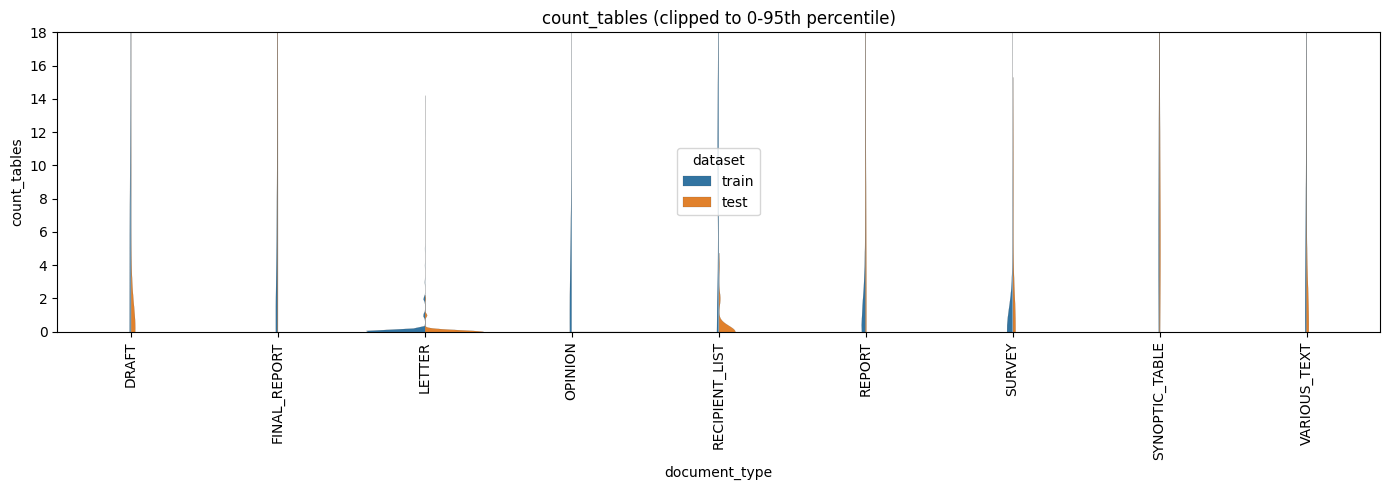

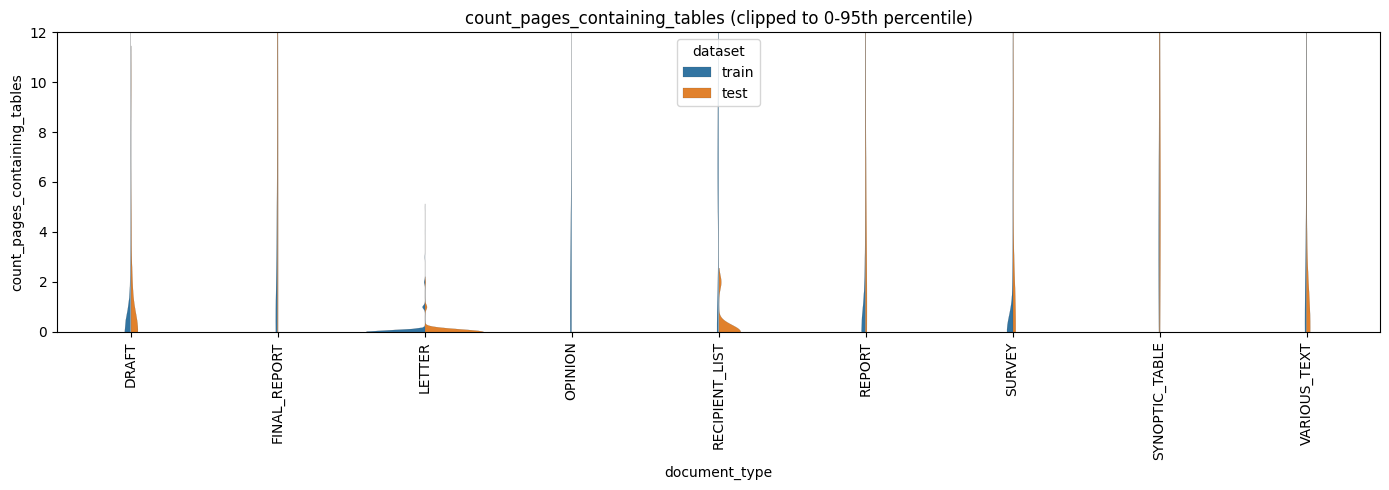

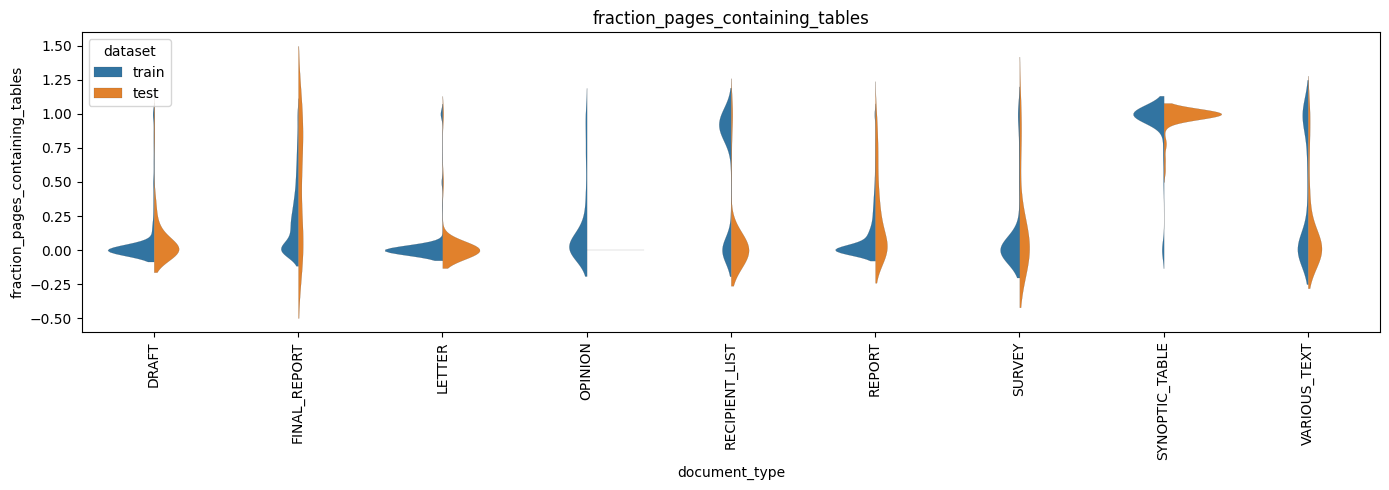

In [27]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "fraction_pages_containing_tables")

### Images

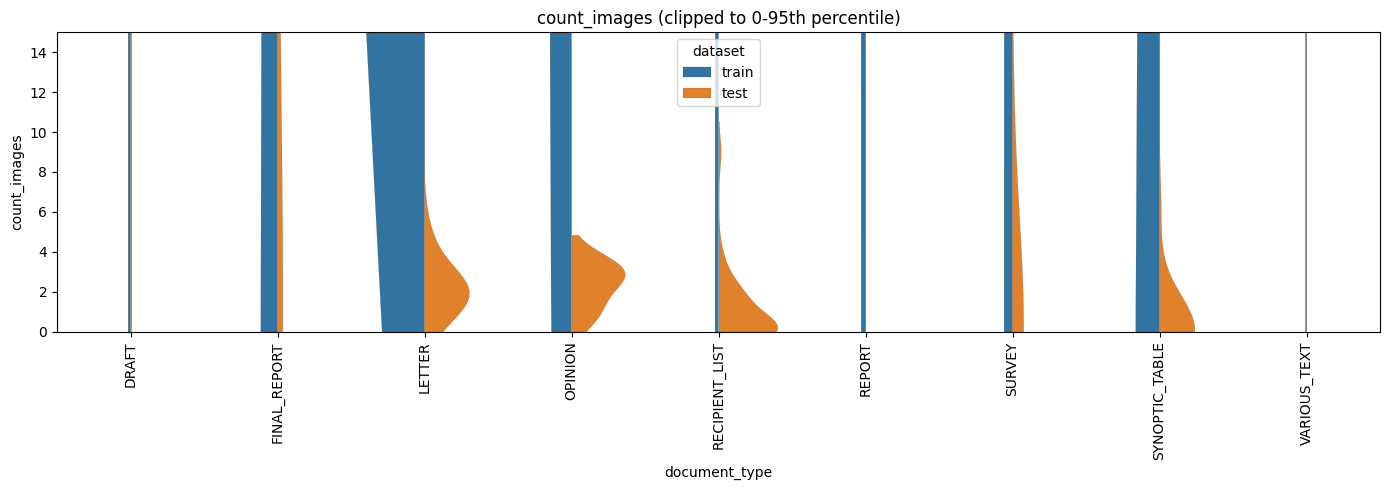

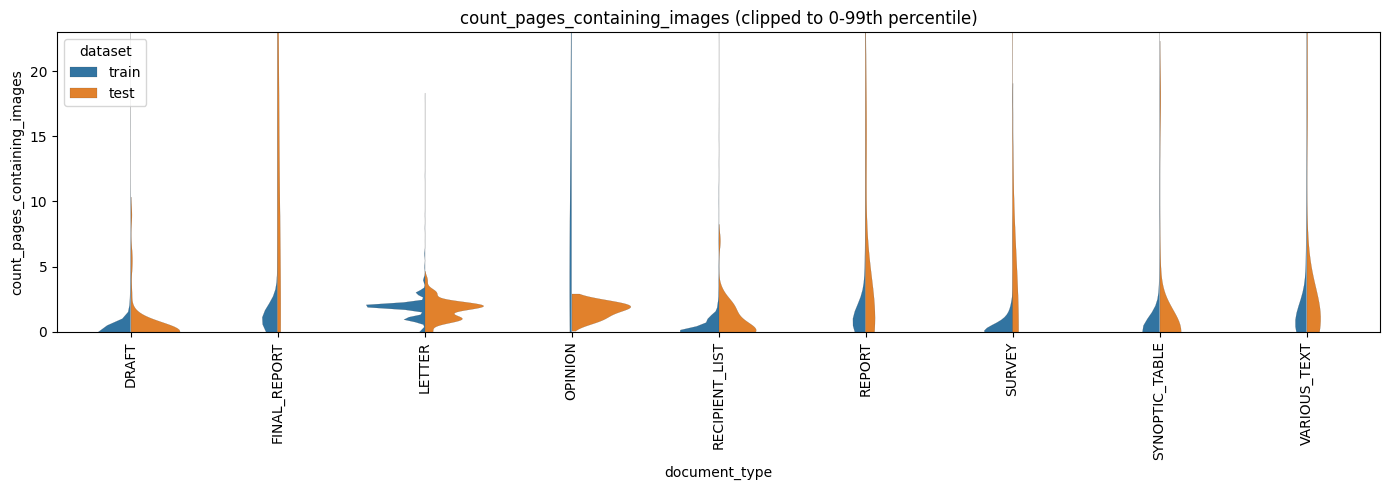

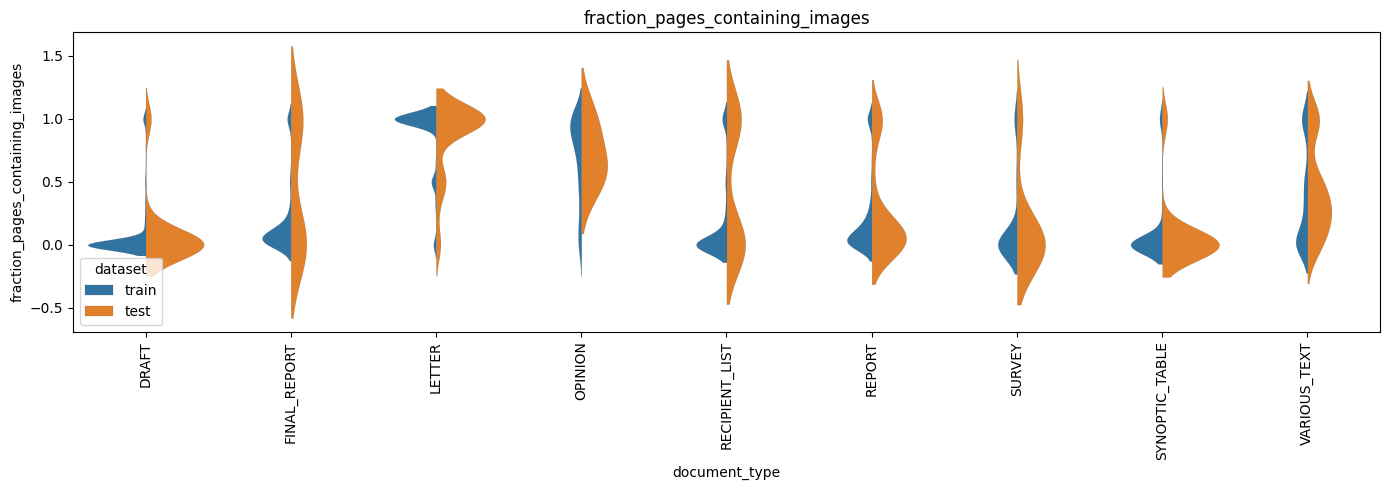

In [28]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "fraction_pages_containing_images")

### Time features

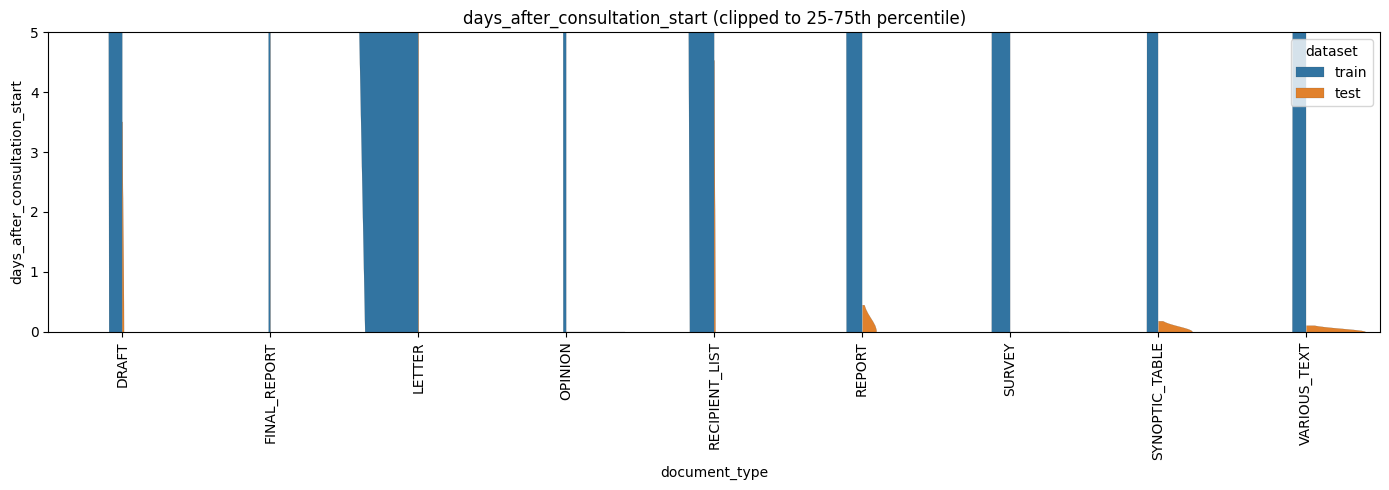

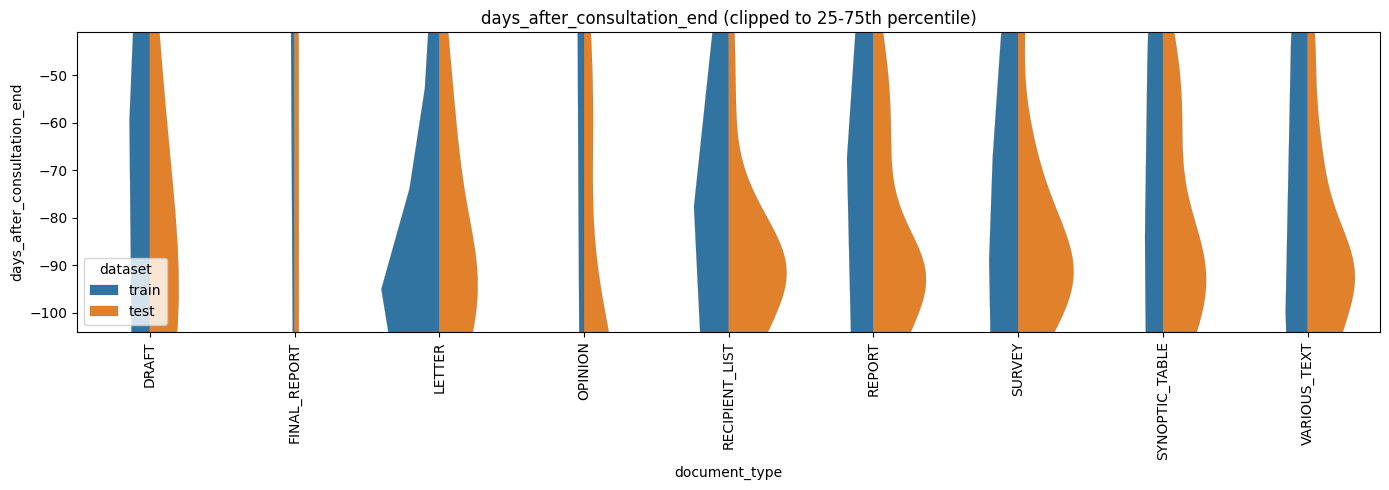

In [29]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

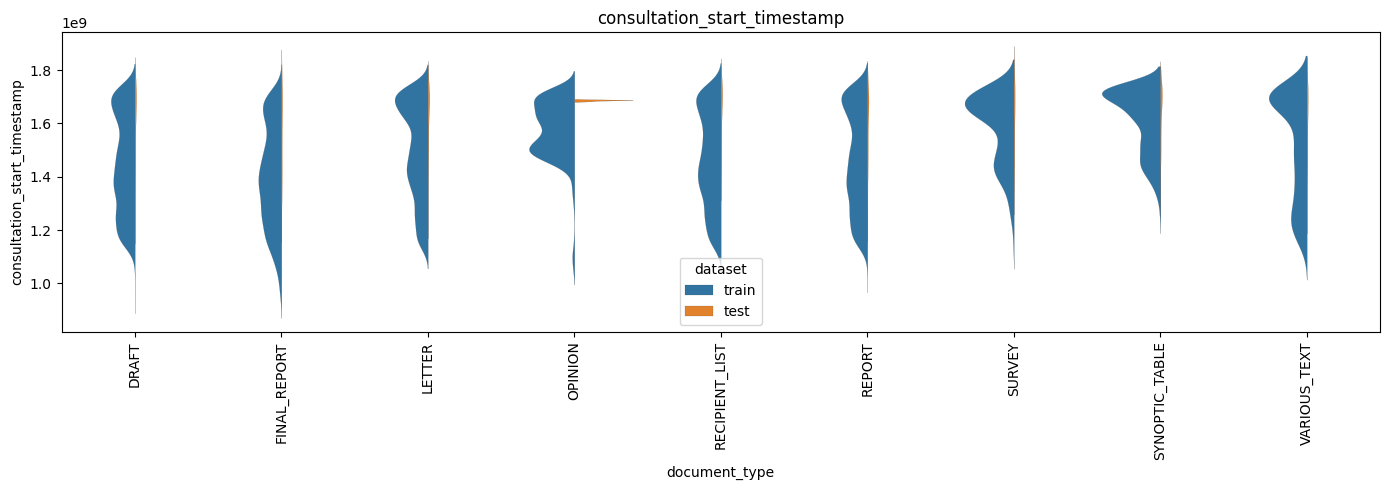

In [30]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

# Classification

In [31]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train)
X_test, y_test = demokratis_ml.models.document_types.model.create_matrices(df_input_test)

print("train", X_train.shape)
print("test", X_test.shape)

train (15275, 3084)
test (456, 3084)


In [32]:
classifier = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    random_state=RANDOM_STATE,
)
classifier

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=CV_FOLDS,
        shuffle=True,
        random_state=RANDOM_STATE,
    ),
    scoring=scoring,
)
scores_docs

{'fit_time': array([6.52582598, 6.95408273, 7.22243214, 7.35391307, 7.45297098]),
 'score_time': array([0.17752409, 0.2651391 , 0.24759793, 0.39765096, 0.45879817]),
 'test_precision': array([0.95014914, 0.93931833, 0.95091149, 0.94790689, 0.94594899]),
 'test_recall': array([0.9512275 , 0.94042553, 0.95155483, 0.94893617, 0.94664484]),
 'test_f1': array([0.94869245, 0.93720351, 0.94934974, 0.94635329, 0.9449842 ]),
 'test_pca_explained_variance': array([0.51214433, 0.51244247, 0.51182073, 0.51146764, 0.51263893]),
 'test_accuracy': array([0.9512275 , 0.94042553, 0.95155483, 0.94893617, 0.94664484]),
 'test_top_k_accuracy': array([0.98330606, 0.98363339, 0.98592471, 0.98330606, 0.98134206])}

## CV evaluation

In [34]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in scores_docs.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9478,
 'cv_f1': 0.9453,
 'cv_pca_explained_variance': 0.5121,
 'cv_precision': 0.9468,
 'cv_recall': 0.9478,
 'cv_top_k_accuracy': 0.9835}


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [35]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [36]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/06/09 14:06:37 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/09 14:06:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.92      0.94      0.93       614
  FINAL_REPORT       0.98      0.97      0.97       368
        LETTER       0.98      1.00      0.99       661
       OPINION       0.99      0.98      0.98       179
RECIPIENT_LIST       1.00      1.00      1.00       435
        REPORT       0.89      0.96      0.92       506
        SURVEY       1.00      0.88      0.94        41
SYNOPTIC_TABLE       0.92      0.92      0.92       118
  VARIOUS_TEXT       0.91      0.53      0.67       133

      accuracy                           0.95      3055
     macro avg       0.95      0.91      0.93      3055
  weighted avg       0.95      0.95      0.95      3055



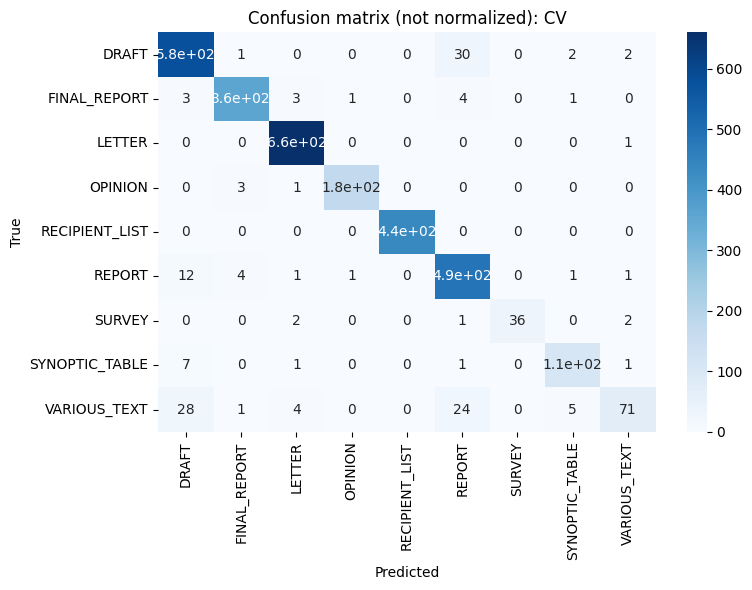

In [37]:
report = sklearn.metrics.classification_report(y_cv_test, cv_test_predictions, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

## Evaluation on the test set

2025/06/09 14:06:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/09 14:07:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.91      0.81      0.85        62
  FINAL_REPORT       1.00      0.28      0.43        18
        LETTER       0.95      1.00      0.97        92
       OPINION        nan      0.00      0.00         5
RECIPIENT_LIST       1.00      1.00      1.00        42
        REPORT       0.71      0.94      0.81       109
        SURVEY       1.00      0.83      0.91        12
SYNOPTIC_TABLE       0.92      0.94      0.93        50
  VARIOUS_TEXT       0.90      0.68      0.78        66

      accuracy                           0.86       456
     macro avg       0.92      0.72      0.74       456
  weighted avg       0.88      0.86      0.85       456



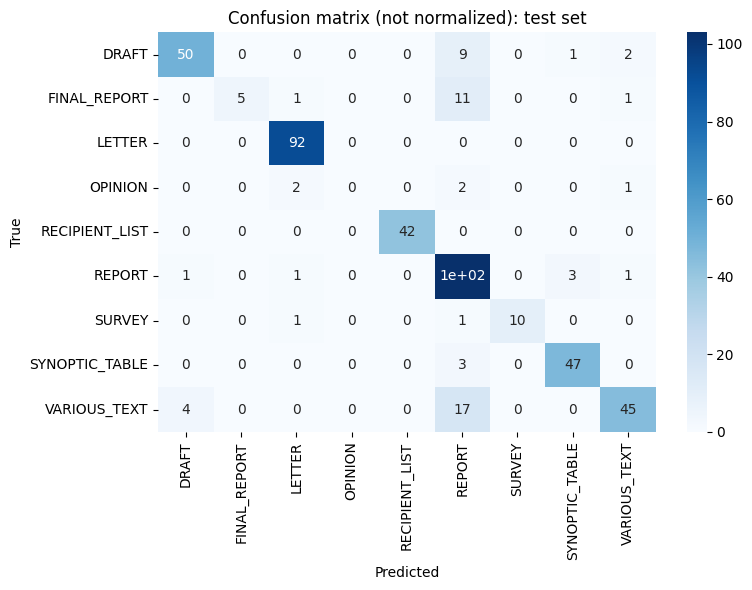

{'test_accuracy': 0.864,
 'test_f1': 0.8533,
 'test_precision': 0.8825,
 'test_recall': 0.864,
 'test_top_k_accuracy': 0.9627}


In [38]:
if USE_TEST_SET:
    # Training & OOS predictions
    classifier_test = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
    )
    classifier_test.fit(X_train, y_train)
    y_test_predicted = classifier_test.predict(X_test)

    # Classification report
    report = sklearn.metrics.classification_report(
        y_test,
        y_test_predicted,
        zero_division=np.nan,
    )
    mlflow.log_text(report, "test_classification_report.txt")
    print(report)

    # Confusion matrix
    cm = plotting.plot_confusion_matrix_heatmap(y_test, y_test_predicted, title="test set")
    mlflow.log_figure(cm, "test_confusion_matrix.png")
    display(cm)

    # Metrics
    p_r_f1 = sklearn.metrics.precision_recall_fscore_support(
        y_test,
        y_test_predicted,
        average="weighted",
        zero_division=np.nan,
    )
    utils.log_metrics(
        test_precision=p_r_f1[0],
        test_recall=p_r_f1[1],
        test_f1=p_r_f1[2],
        test_accuracy=sklearn.metrics.accuracy_score(y_test, y_test_predicted),
        test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test, classifier_test.predict_proba(X_test)),
    )

### Feature importance

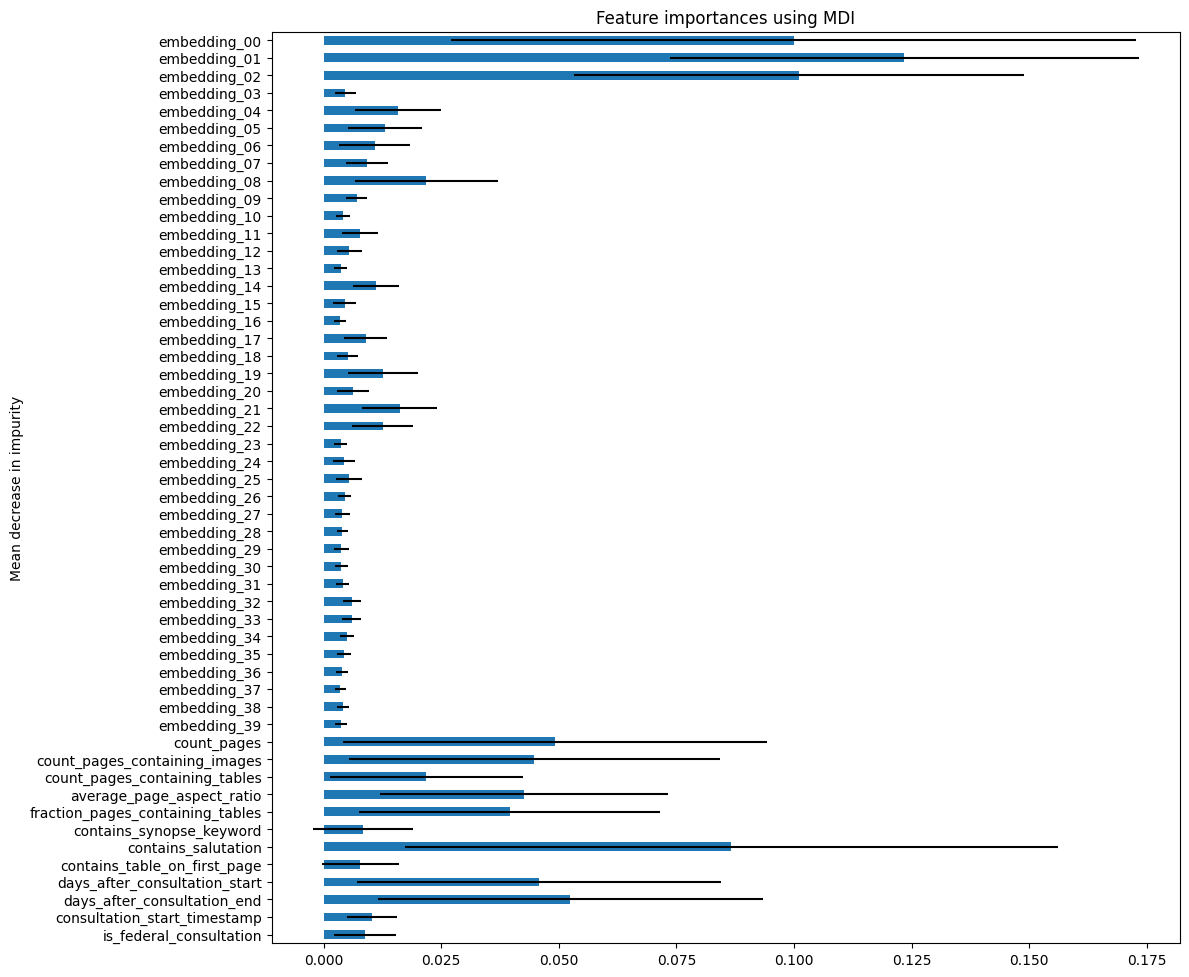

In [39]:
forest = classifier_test.named_steps["randomforestclassifier"]
pca = demokratis_ml.models.document_types.model.get_pca_step(classifier_test)
assert pca is not None

forest_importances = pd.Series(
    forest.feature_importances_,
    index=(
        [f"embedding_{i:02d}" for i in range(pca.n_components)]
        + list(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS)
        + list(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
    ),
)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(12, 2.5 * np.log(len(forest_importances))))
forest_importances.plot.barh(xerr=std, ax=ax)
ax.invert_yaxis()  # start with embeddings at the top
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

mlflow.log_figure(fig, "feature_importance_mdi.png")

### Results per canton

In [40]:
df_eval = df_input_test.copy()
df_eval["document_type_predicted"] = y_test_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
ag
------------------------------------------------------------
                precision    recall  f1-score   support

        LETTER       0.88      1.00      0.93         7
RECIPIENT_LIST       1.00      1.00      1.00         7
        REPORT       0.83      0.91      0.87        11
        SURVEY       1.00      1.00      1.00         7
SYNOPTIC_TABLE       1.00      1.00      1.00         8
  VARIOUS_TEXT        nan      0.00      0.00         2

      accuracy                           0.93        42
     macro avg       0.94      0.82      0.80        42
  weighted avg       0.93      0.93      0.91        42


------------------------------------------------------------
ai
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       1.00      0.80      0.89         5
        LETTER       1.00      1.00      1.00         7
        REPORT  

## Comparison: rule-based model

In [41]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df),
    demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.22% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.73% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.32% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
WARNING document

                precision    recall  f1-score   support

         DRAFT       0.72      1.00      0.83        48
  FINAL_REPORT       1.00      0.20      0.33         5
        LETTER       1.00      1.00      1.00        90
       OPINION        nan      0.00      0.00         1
RECIPIENT_LIST       1.00      1.00      1.00        33
        REPORT       0.91      0.89      0.90        93
        SURVEY       1.00      0.82      0.90        11
SYNOPTIC_TABLE       1.00      0.81      0.90        43
  VARIOUS_TEXT       0.93      0.87      0.90        30

      accuracy                           0.92       354
     macro avg       0.94      0.73      0.75       354
  weighted avg       0.93      0.92      0.92       354



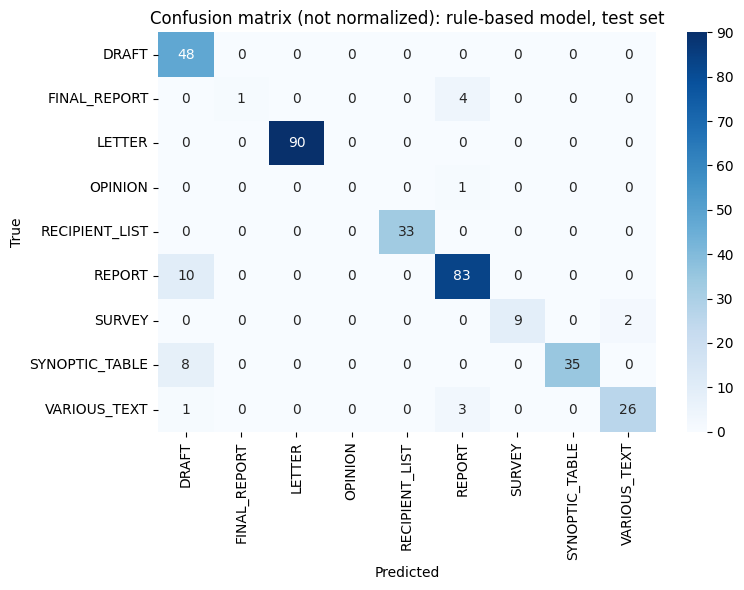

In [42]:
_y_true = y_test[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title="rule-based model, test set",
    # normalize="true",
)

## Display all test samples & predictions

In [43]:
df_display = df_input_test.copy()
df_display["prediction_rule"] = y_test_predicted_rules
df_display["prediction_ml"] = y_test_predicted

df_display[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).apply(
    lambda row: [
        f'color: {"green" if row[col] == row["document_type"] else "red"}'
        if col in {"prediction_rule", "prediction_ml"}
        else ""
        for col in row.index
    ],
    axis=1,
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
44702,45445,tg,vnl,doc,Synopse LBV,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
47383,48384,zh,vnl,doc,Erläuterungsbericht und Synopse PBG,REPORT,REPORT,REPORT
47409,48412,zh,vnl,doc,Auszug aus dem Protokoll des RR,VARIOUS_TEXT,nan,VARIOUS_TEXT
49128,50278,lu,vnl,doc,Entwurf Gesetz (OWG),DRAFT,DRAFT,DRAFT
46131,47112,zh,vnl,doc,Erläuterungen zum Entwurf PVG,REPORT,REPORT,REPORT
47254,48250,zh,vnl,doc,Auszug aus dem Protokoll des RR,VARIOUS_TEXT,nan,VARIOUS_TEXT
51426,53187,ag,vnl,doc,Anhörungsbericht,REPORT,REPORT,REPORT
40073,40248,ar,vnl,doc,Verzeichnis der Vernehmlassungsadressaten,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
47646,48682,tg,vnl,doc,Mitwirkungsbericht TG KVG,FINAL_REPORT,nan,REPORT
42730,43436,lu,vnl,doc,Einladungsschreiben,LETTER,LETTER,LETTER


***

# End run

In [44]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [45]:
mlflow.end_run()

🏃 View run grandiose-grouse-888 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/ba3c515bf70c4d40ae430325fbb3ca29
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4
